In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r'C:\Users\ashbat\Desktop\totalByWeekWHOther Vegies.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'W-MON'

In [3]:
df.head()

,TOTAL_PRICESELL,holidayWeekS
DATE,,
2016-03-14,391.02186,0
2016-03-21,669.11098,71
2016-03-28,1044.53012,0
2016-04-04,1022.45874,0
2016-04-11,752.92608,0


In [4]:
print(df.index.freq)

<Week: weekday=0>


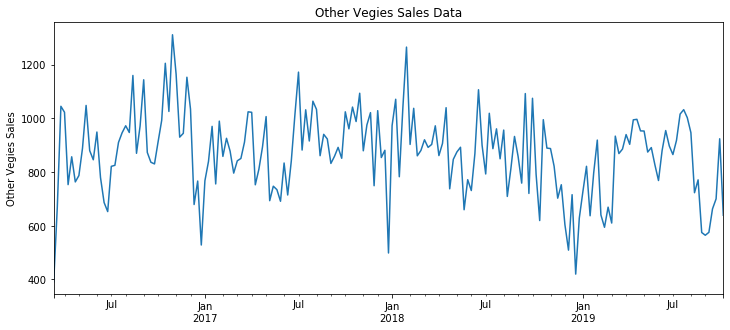

In [5]:
title='Other Vegies Sales Data'
ylabel='Other Vegies Sales'
xlabel='' 

ax = df['TOTAL_PRICESELL'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

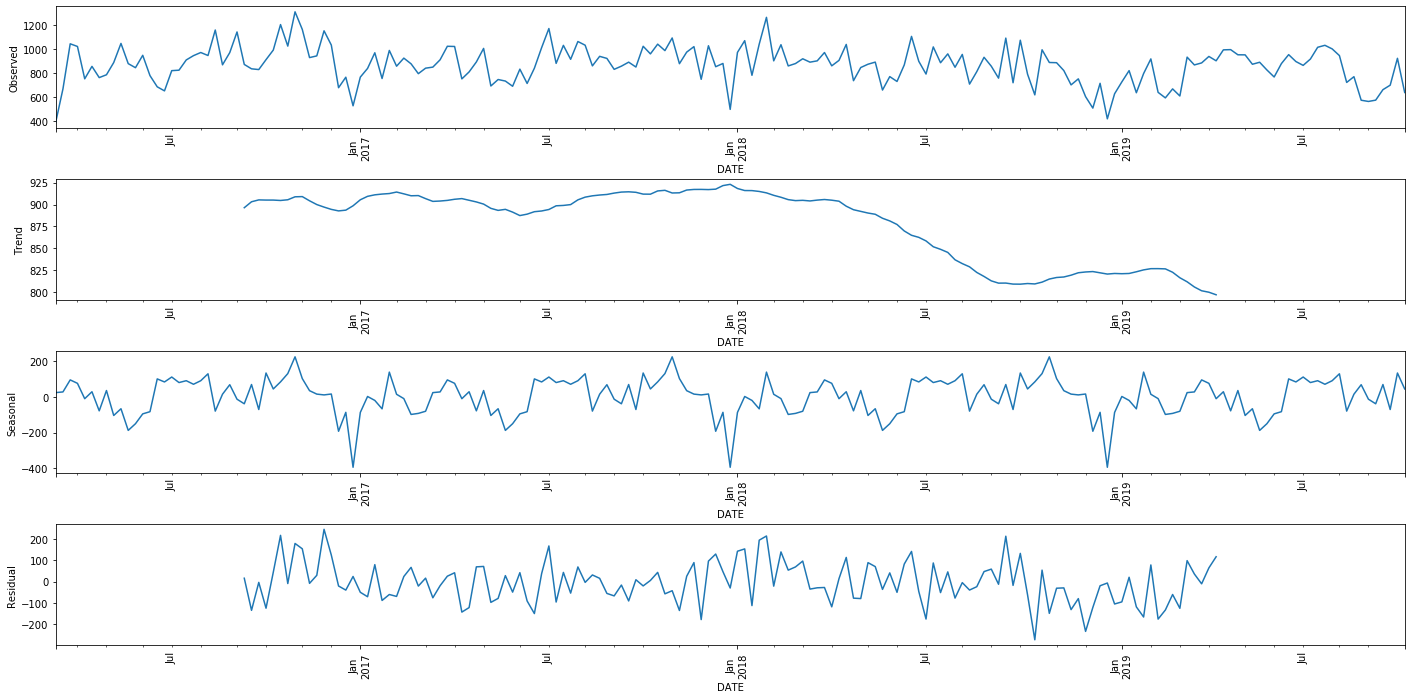

In [6]:
result = seasonal_decompose(df['TOTAL_PRICESELL'], model='add')

observed = result.observed
trend = result.trend
seasonal =  result.seasonal
residual =  result.resid

decomp_data = pd.DataFrame({"Observed":observed, "Trend": trend, "Seasonal":seasonal,"Residual":residual})

import matplotlib.pyplot as plt

figure, axes = plt.subplots(nrows=4,ncols=1, figsize=(20, 10))
figure.tight_layout(pad=3.0)
for i, ax in enumerate(axes):
    ax = decomp_data.iloc[:,i].plot(ax=ax)
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_major_formatter(years_fmt)
#     ax.xaxis.set_minor_locator(months)
#     ax.xaxis.set_minor_formatter(fmt)
    ax.set_ylabel(decomp_data.iloc[:,i].name)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

figure.savefig('othervegies_decomp.png')

In [7]:
#auto_arima(df['TOTAL_PRICESELL'],seasonal=True,m=52).summary()

In [8]:
train = df.iloc[:len(df)-52]
test = df.iloc[len(df)-52:]

In [9]:
#Train on training data set
model = SARIMAX(train['TOTAL_PRICESELL'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    TOTAL_PRICESELL   No. Observations:                  135
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 52)   Log Likelihood                -855.937
Date:                            Sun, 17 May 2020   AIC                           1719.874
Time:                                    11:42:14   BIC                           1731.465
Sample:                                03-14-2016   HQIC                          1724.584
                                     - 10-08-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8537      0.053    -16.003      0.000      -0.958      -0.749
ar.S.L52      -0.5015      1.221     -0.411      0.681      -2.894       1.892
ma.S.L52       0.7958      1.744      0.456      0.648      -2.622       4.213
sigma2      1.894e+04   1.08e+04      1.759      0.079   -2166.934       4e+04
===================================================================================
Ljung-Box (Q):                       44.52   Jarque-Bera (JB):                 1.85
Prob(Q):                              0.29   Prob(JB):                         0.40
Heteroskedasticity (H):               0.63   Skew:                             0.09
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')

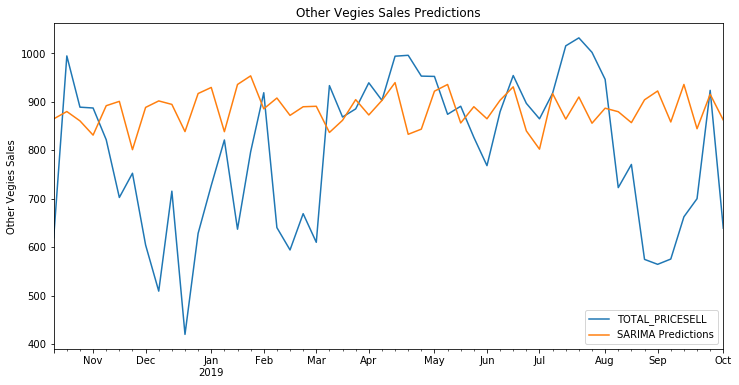

In [11]:
#Compare to validation data
title='Other Vegies Sales Predictions'
ylabel='Other Vegies Sales'
xlabel=''

ax = test['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [12]:
error1 = mean_squared_error(test['TOTAL_PRICESELL'], predictions)
error2 = rmse(test['TOTAL_PRICESELL'], predictions)
print(f'SARIMA MSE: {error1:11.10}')
print(f'SARIMA RMSE: {error2:11.10}')

SARIMA MSE: 33127.81647
SARIMA RMSE: 182.0104845


In [13]:
#Retrain on full data set and make a forecast for 12 weeks out
model = SARIMAX(df['TOTAL_PRICESELL'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA Forecast')

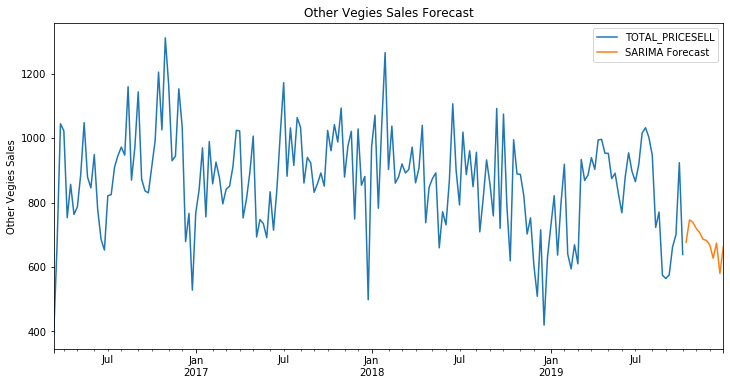

In [14]:
title='Other Vegies Sales Forecast'
ylabel='Other Vegies Sales'
xlabel=''

ax = df['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [15]:
train = df.iloc[:len(df)-52]
test = df.iloc[len(df)-52:]

In [16]:
train.head()

,TOTAL_PRICESELL,holidayWeekS
DATE,,
2016-03-14,391.02186,0
2016-03-21,669.11098,71
2016-03-28,1044.53012,0
2016-04-04,1022.45874,0
2016-04-11,752.92608,0


In [17]:
#Train on training data set
model = SARIMAX(train['TOTAL_PRICESELL'],exog=train['holidayWeekS'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    TOTAL_PRICESELL   No. Observations:                  135
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 52)   Log Likelihood                -854.391
Date:                            Sun, 17 May 2020   AIC                           1718.782
Time:                                    11:42:23   BIC                           1733.271
Sample:                                03-14-2016   HQIC                          1724.670
                                     - 10-08-2018                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
holidayWeekS    -2.0122      0.643     -3.131      0.002      -3.272      -0.753
ma.L1           -0.8901      0.043    -20.754      0.000      -0.974      -0.806
ar.S.L52        -0.3979      1.313     -0.303      0.762      -2.971       2.175
ma.S.L52         0.6121      1.404      0.436      0.663      -2.140       3.364
sigma2        1.933e+04   3427.845      5.639      0.000    1.26e+04     2.6e+04
===================================================================================
Ljung-Box (Q):                       45.07   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.27   Prob(JB):                         0.60
Heteroskedasticity (H):               0.73   Skew:                             0.19
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holidayWeekS']] 
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX Predictions')
error1 = mean_squared_error(test['TOTAL_PRICESELL'], predictions)
error2 = rmse(test['TOTAL_PRICESELL'], predictions)
print(f'SARIMAX MSE: {error1:11.10}')
print(f'SARIMAX RMSE: {error2:11.10}')

SARIMAX MSE: 31769.45613
SARIMAX RMSE: 178.2398837


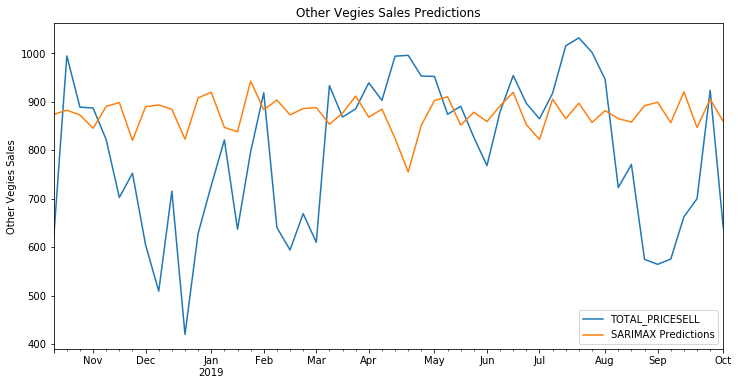

In [19]:
#Compare to validation data
title='Other Vegies Sales Predictions'
ylabel='Other Vegies Sales'
xlabel=''

ax = test['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [20]:
#Retrain on full data set and make a forecast for 12 weeks out
model = SARIMAX(df['TOTAL_PRICESELL'],exog=df['holidayWeekS'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()

In [21]:
start=len(df)
end=len(df) + 11
exog_forecast = pd.read_csv(r'C:\Users\ashbat\Desktop\ExogHolidays.csv',index_col='DATE',parse_dates=True)
exog_forecast.index.freq = 'W-MON'
exog_forecast = exog_forecast[['holidayWeekS']]
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX Predictions')

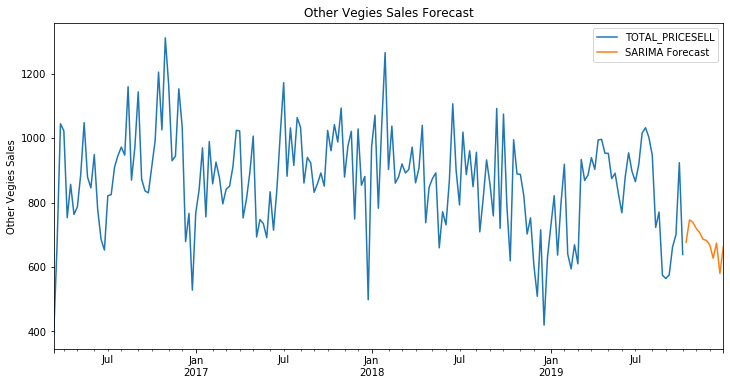

In [22]:
title='Other Vegies Sales Forecast'
ylabel='Other Vegies Sales'
xlabel=''

ax = df['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);